<a href="https://colab.research.google.com/github/ArnyWu/DeepGenerativeModels/blob/main/7113029049_VAE0918.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1, Train AVG Loss: 165.7154, Test AVG Loss: 128.6454
Epoch 2, Train AVG Loss: 121.8592, Test AVG Loss: 115.7461
Epoch 3, Train AVG Loss: 114.6373, Test AVG Loss: 111.7289
Epoch 4, Train AVG Loss: 111.6518, Test AVG Loss: 109.7977
Epoch 5, Train AVG Loss: 109.8914, Test AVG Loss: 108.5937
Epoch 6, Train AVG Loss: 108.7213, Test AVG Loss: 107.7819
Epoch 7, Train AVG Loss: 107.8573, Test AVG Loss: 106.9158
Epoch 8, Train AVG Loss: 107.2158, Test AVG Loss: 106.3340
Epoch 9, Train AVG Loss: 106.7228, Test AVG Loss: 105.8871
原始影像張量形狀：(1, 1, 28, 28)
Decoder 輸出形狀：(1, 784)
還原成影像形狀： (1, 1, 28, 28)


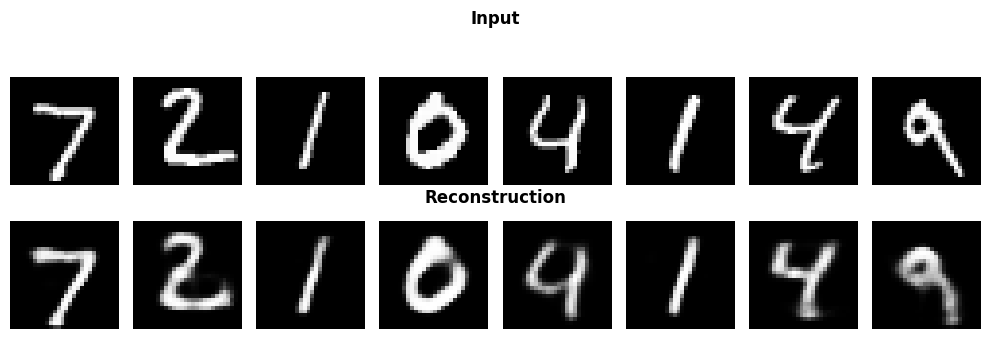

已存檔：final_reconstruction.jpg
Epoch 10, Train AVG Loss: 106.2973, Test AVG Loss: 105.7605


In [ ]:
import os
import gzip
import struct
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
from urllib.request import urlretrieve

# 載入 MNIST 資料集
def load_images(filename, num_samples):
    with gzip.open(filename, 'rb') as f:
        magic = struct.unpack(">I", f.read(4))[0]
        if magic != 2051: #0x3080000
            raise ValueError("Invalid magic number in image file!")
        n_images = struct.unpack(">I", f.read(4))[0]
        rows = struct.unpack(">I", f.read(4))[0]
        cols = struct.unpack(">I", f.read(4))[0]
        if n_images != num_samples:
            raise ValueError("Image count does not match expected!")
        buf = f.read(rows * cols * n_images)
        data = np.frombuffer(buf, dtype=np.uint8)
        data = data.reshape(n_images, rows, cols).astype(np.float32) / 255.0
        return data

def load_labels(filename, num_samples):
    with gzip.open(filename, 'rb') as f:
        magic = struct.unpack(">I", f.read(4))[0]
        if magic != 2049:  #0x1080000
            raise ValueError("Invalid magic number in label file!")
        n_labels = struct.unpack(">I", f.read(4))[0]
        if n_labels != num_samples:
            raise ValueError("Label count does not match expected!")
        buf = f.read(n_labels)
        labels = np.frombuffer(buf, dtype=np.uint8)
        return labels

def get_mnist():
    server = 'https://raw.githubusercontent.com/fgnt/mnist/master'
    files = {
        "train_images": ("train-images-idx3-ubyte.gz", 60000),
        "train_labels": ("train-labels-idx1-ubyte.gz", 60000),
        "test_images":  ("t10k-images-idx3-ubyte.gz", 10000),
        "test_labels":  ("t10k-labels-idx1-ubyte.gz", 10000),
    }

    # 檔案下載
    for k, (fname, _) in files.items():
        if not os.path.exists(fname):
            print(f"Downloading {fname}...")
            urlretrieve(f"{server}/{fname}", fname)

    train_images = load_images(files["train_images"][0], files["train_images"][1])
    train_labels = load_labels(files["train_labels"][0], files["train_labels"][1])
    test_images = load_images(files["test_images"][0], files["test_images"][1])
    test_labels = load_labels(files["test_labels"][0], files["test_labels"][1])

    return train_images, train_labels, test_images, test_labels

# VAE 模型
class VAE(nn.Module):
    '''
    1. Encoder 將輸入 28x28 圖像（展平為784維向量）轉換為潛在空間的均值（mu）與對數方差（logvar）
    2. 使用 reparameterization trick 產生潛在變數 z
    3. Decoder 將 z 解碼回圖像空間，重建輸入圖像
    '''
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar

    # reparameterization trick (z = mu + eps * std)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h2))

    def forward(self, x):
        # 攤平成784
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

# Loss Function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# 形狀確認
@torch.no_grad()
def shape_demo(model, batch, device):
    one = batch[:1].to(device)
    recon_one, _, _ = model(one)
    recon_img = recon_one.view(-1,1,28,28)
    print(f"原始影像張量形狀：{tuple(one.shape)}")
    print(f"Decoder 輸出形狀：{tuple(recon_one.shape)}")
    print(f"還原成影像形狀： {tuple(recon_img.shape)}")

# 訓練
def train_vae(model, train_loader, optimizer, device):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    #平均損失
    return train_loss / len(train_loader.dataset)

# 測試
def test_vae(model, test_loader, device, show_and_save=False, save_path="final_reconstruction.jpg", do_shape_demo=False):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

            # 顯示前 8 張測試圖片與重建結果
            if i == 0:
                if do_shape_demo:
                  shape_demo(model, data, device)
                if show_and_save:
                  n = min(data.size(0), 8)
                  inputs = data[:n].cpu()
                  recons = recon_batch.view(-1, 1, 28, 28)[:n].cpu()
                  fig = plt.figure(figsize=(10, 3.8))

                  fig.text(0.5, 0.95, "Input", ha='center', va='center', fontsize=12, weight='bold')
                  fig.text(0.5, 0.48, "Reconstruction", ha='center', va='center', fontsize=12, weight='bold')

                  for j in range(n):
                      ax = plt.subplot(2, n, j+1)
                      ax.imshow(inputs[j, 0], cmap='gray')
                      ax.axis('off')
                  for j in range(n):
                      ax = plt.subplot(2, n, n + j + 1)
                      ax.imshow(recons[j, 0], cmap='gray')
                      ax.axis('off')

                  plt.tight_layout(rect=[0, 0, 1, 0.93])
                  plt.savefig(save_path, dpi=150)
                  plt.show()
                  print(f"已存檔：{save_path}")
    #平均損失
    return test_loss / len(test_loader.dataset)

def main():
    # 載入資料
    train_images, train_labels, test_images, test_labels = get_mnist()

    # 轉換成 Tensor 並建立 DataLoader
    train_tensor = torch.tensor(train_images).unsqueeze(1)  # shape: (60000, 1, 28, 28)
    test_tensor = torch.tensor(test_images).unsqueeze(1)
    train_dataset = torch.utils.data.TensorDataset(train_tensor, torch.tensor(train_labels))
    test_dataset = torch.utils.data.TensorDataset(test_tensor, torch.tensor(test_labels))
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

    # 模型 & 訓練設定
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = VAE().to(device)

    #使用 Adam 優化器
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # 訓練
    epochs = 10
    for epoch in range(1, epochs + 1):
        train_loss = train_vae(model, train_loader, optimizer, device)
        last = (epoch == epochs)
        test_loss = test_vae(model,
                   test_loader,
                   device,
                   show_and_save=last,
                   save_path="final_reconstruction.jpg",
                   do_shape_demo=last)
        print(f"Epoch {epoch}, Train AVG Loss: {train_loss:.4f}, Test AVG Loss: {test_loss:.4f}")

if __name__ == "__main__":
  main()